### Natural Language Processing Project 

### Task: Question Answering using the FQuAD, French Question Answering Dataset

In [1]:
### to reduce the long installation outputs
from IPython.display import clear_output


## importing dependencies
import json
from pathlib import Path
import zipfile

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## word embedding model
import gensim

## filtering out warnings
import warnings
warnings.filterwarnings('ignore')

- Due to the cost of training we have used only 4,500 samples from the train dataset and 800 from the validation dataset. 
- The data used for the training is saved in [this github repository](https://github.com/IkeKobby/nlp_project/raw/main/used_data.zip). 
 - The next cell below download the data into the directory `data` on colab for easy access. Kindly remove the hashtag if it is the first time you are using this notebook.


In [2]:
!mkdir data
!wget https://github.com/IkeKobby/nlp_project/raw/main/used_data.zip -O data/used_data.zip

unzip =zipfile.ZipFile('data/used_data.zip')
unzip.extractall('data/')
unzip.close()

clear_output()

## Global variables
- We used theswe global varibales to help with fine tuning of the model as and when deem necessary. 

In [3]:
# TOKENIZATION
FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
LOWER_CASE = True


# answer model parameters
EPOCHS = 30
BATCH_SIZE = 32
EMBED_SIZE = 200
CLASS_WEIGHTS = {0: 0.5, 1: 5.}

In [23]:
train_data.head(10)


,context,questions,answers,answer_start,answer_end
0,l'idée selon laquelle une planète inconnue pou...,quel astronome a émit l'idée en premier d'une ...,johann elert bode,23,26
1,l'idée selon laquelle une planète inconnue pou...,quel astronome découvrit uranus ?,william herschel,77,79
2,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
3,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
4,"piazzi observa cérès 24 fois, la dernière fois...",combien de fois piazzi est-il parvenu à observ...,24,3,4
5,"piazzi observa cérès 24 fois, la dernière fois...",où se trouvait barnaba oriani en 1801 ?,milan,35,36
6,"piazzi observa cérès 24 fois, la dernière fois...",dans quel revue scientifique fut publiées ces ...,monatliche correspondenz,105,107
7,"piazzi observa cérès 24 fois, la dernière fois...",pourquoi cérès n'était pas directement assimil...,son mouvement est lent et uniforme,49,55
8,"peu après sa découverte, cérès s'approcha trop...",pour quelle raison on ne put plus observer cér...,cérès s'approcha trop près du soleil,5,12
9,"peu après sa découverte, cérès s'approcha trop...",qui est parvenu à déterminer approximativement...,carl friedrich gauss,61,64


### Processed data

## This data has been preprocessed from the original data to fit into the model.
### A link to the helper functions for the various preprocessing we did shall be given access to in the github [link](https://raw.githubusercontent.com/IkeKobby/nlp_project/main/nlp_preoject_helper_functions.py). 


In [4]:
## Data Loading and exploration
train_data = pd.read_csv('data/train_text.csv')
val_data = pd.read_csv('data/val_text.csv')

train_data.shape, val_data.shape

((4500, 5), (800, 5))

In [5]:
train_data.head(10)

,context,questions,answers,answer_start,answer_end
0,l'idée selon laquelle une planète inconnue pou...,quel astronome a émit l'idée en premier d'une ...,johann elert bode,23,26
1,l'idée selon laquelle une planète inconnue pou...,quel astronome découvrit uranus ?,william herschel,77,79
2,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
3,l'idée selon laquelle une planète inconnue pou...,quelles furent les découvertes finales des vin...,plusieurs autres astéroïdes,135,138
4,"piazzi observa cérès 24 fois, la dernière fois...",combien de fois piazzi est-il parvenu à observ...,24,3,4
5,"piazzi observa cérès 24 fois, la dernière fois...",où se trouvait barnaba oriani en 1801 ?,milan,35,36
6,"piazzi observa cérès 24 fois, la dernière fois...",dans quel revue scientifique fut publiées ces ...,monatliche correspondenz,105,107
7,"piazzi observa cérès 24 fois, la dernière fois...",pourquoi cérès n'était pas directement assimil...,son mouvement est lent et uniforme,49,55
8,"peu après sa découverte, cérès s'approcha trop...",pour quelle raison on ne put plus observer cér...,cérès s'approcha trop près du soleil,5,12
9,"peu après sa découverte, cérès s'approcha trop...",qui est parvenu à déterminer approximativement...,carl friedrich gauss,61,64


In [6]:
val_data.head(10)

,context,questions,answers,answer_start,answer_end
0,les deux tableaux sont certes décrits par des ...,que concerne principalement les documents ?,la vierge aux rochers,25,29
1,les deux tableaux sont certes décrits par des ...,par quoi sont décrit les deux tableaux ?,documents contemporains,8,10
2,les deux tableaux sont certes décrits par des ...,quels types d'objets sont les deux tableaux au...,objets de spéculations,33,36
3,les deux panneaux présentent de nombreuses sim...,sur quelle jambe les personnages se tiennent-t...,droite,43,44
4,les deux panneaux présentent de nombreuses sim...,quel pied avancent les personnages ?,gauche,48,49
5,les deux panneaux présentent de nombreuses sim...,de quelle couleur est l'ange qui joue de la li...,vert,140,141
6,les chercheurs s'accordent pour considérer que...,d'où sont issus les deux panneaux ?,atelier de léonard de vinci,14,19
7,les chercheurs s'accordent pour considérer que...,lors de quel processus des craquelures apparai...,séchage,100,101
8,les chercheurs s'accordent pour considérer que...,qu'est ce qui est utilisé pour la finition des...,doigts,64,65
9,les chercheurs s'accordent pour considérer que...,quel est le nom du panneau central du retable ?,la vierge aux rochers,33,37


In [7]:
## retrieving the maximum sentence length fromt the context of the text. 
def get_MAX_LEN(column):
  tok = []
  for sent in column:
    tok.append(len(sent.split()))
  get_max = max(np.array(tok))
  return get_max 

MAX_LEN = get_MAX_LEN(train_data.context)
MAX_LEN

503

In [8]:
### A functionalized tokenizer that performs tokenization on the text columns of the data.
def define_tokenizer(df_series):
    sentences = pd.concat(df_series)
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=FILTERS, 
        lower=LOWER_CASE
    )
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

## An encoder function that takes into effects the tokenized method and paired sentences and encode them numerically  
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_sentences, 
        padding='post',
        maxlen=MAX_LEN
    )
    
    return encoded_sentences

In [9]:
## fitting the tokenizer with the required sentences
tokenizer = define_tokenizer([
    train_data.context, 
    train_data.questions,
    val_data.context, 
    val_data.questions
])

In [10]:
### Getting the encodings for each sentences paired with respective questions. 
train_context = encode(train_data.context.values, tokenizer)
train_questions = encode(train_data.questions.values, tokenizer)

val_context = encode(val_data.context.values, tokenizer)
val_questions = encode(val_data.questions.values, tokenizer)

In [11]:
## checking the encoding sizes
train_context.shape, train_questions.shape, val_context.shape, val_questions.shape

((4500, 503), (4500, 503), (800, 503), (800, 503))

In [12]:
### A function that returns one-hot encoded labels for the output variables, thus, the start_tokens, end_tokens, in a dimension of the maximum sentence length
## With zeroes everywhere but for the position of the start and end tokens.

def form_answer_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    for i in range(len(df)):
        start = df.loc[i].answer_start
        end = df.loc[i].answer_end

        if start < sentence_length and end < sentence_length:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels

### instantiating the function with the rewuired data.
train_start_labels, train_end_labels = form_answer_labels(train_data, MAX_LEN)
val_start_labels, val_end_labels = form_answer_labels(val_data, MAX_LEN)

In [13]:
### Printing out the representing of the start and end tokens.
print(train_data.loc[0].context)
print('Start index: {0}'.format(train_start_labels[0]))
print('End index: {0}'.format(train_end_labels[0]))

l'idée selon laquelle une planète inconnue pourrait exister entre les orbites de mars et jupiter fut proposée pour la première fois par johann elert bode en 1768. ses suggestions étaient basées sur la loi de titius-bode, une théorie désormais obsolète proposée par johann daniel titius en 1766,. selon cette loi, le demi-grand axe de cette planète aurait été d'environ 2,8 ua. la découverte d'uranus par william herschel en 1781 accrut la confiance dans la loi de titius-bode et, en 1800, vingt-quatre astronomes expérimentés combinèrent leurs efforts et entreprirent une recherche méthodique de la planète proposée,. le groupe était dirigé par franz xaver von zach. bien qu'ils n'aient pas découvert cérès, ils trouvèrent néanmoins plusieurs autres astéroïdes.
Start index: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.

#### Model training 

In [14]:
### We used LSTM for the training of the questions and answers.
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

> We also trained an embedding on french texts to help with our french question answering task. A link to the text we trained the embedding on shall be provided [here](https://raw.githubusercontent.com/Ismailhachimi/French-Word-Embeddings/master/Data/data.txt). 

> The embedding shall also be added to the github repository for projects with French tasks. However, in the meantime here is a [google drive link](https://drive.google.com/drive/folders/1fJPM3efcUR5wbS7ml2A12_4_wp8QUQRu?usp=sharing) to the file on request for verification. 


In [15]:
## Using a trained model on french text
model_w2v = gensim.models.Word2Vec.load('/content/drive/MyDrive/KOBBY/ML and AI data/NLP/model_fr_w2v/w2v_cbow_200D')

### Create embedding dictionary for each french word from our dataset
embedding_dic = {}

for word in model_w2v.wv.vocab:
  embedding_dic[word] = model_w2v.wv.__getitem__(word)


num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, EMBED_SIZE))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dic.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [16]:
## We built the model with the embedding layer on top top of the LSTM

### embedding layer 
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    EMBED_SIZE,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

# encode question
question_input = Input(shape=(None,))
question_x = embedding(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(300, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encode answer
answer_input = Input(shape=(None,))
answer_x = embedding(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(100, return_sequences=True))(answer_x)


# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token_out')(start_x)

# predict end index
end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token_out')(end_x)

# merge the parts into one model
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

In [17]:
## compiling the model with three metrics
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision']
)

## defining a call back to check with the model training and performance over time.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [18]:
### We fit the model and save the history for visualization and monitoring of the model performance
history = model.fit(
    x = [train_context, train_questions], 
    y = [train_start_labels, train_end_labels],
    validation_data = (
        [val_context, val_questions], 
        [val_start_labels, val_end_labels]
    ),
    epochs = EPOCHS,
    callbacks = callbacks,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Epoch 1/30
 29/141 [=====>........................] - ETA: 38:57 - loss: 9.8695 - start_token_out_loss: 4.9217 - end_token_out_loss: 4.9478 - start_token_out_categorical_accuracy: 0.0162 - start_token_out_recall: 0.0000e+00 - start_token_out_precision: 0.0000e+00 - end_token_out_categorical_accuracy: 0.0129 - end_token_out_recall_1: 0.0000e+00 - end_token_out_precision_1: 0.0000e+00

KeyboardInterrupt: ignored

In [1]:
## We check for number of epochs and the best loss achieved.
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

NameError: ignored

### Model Performance Visualizations 

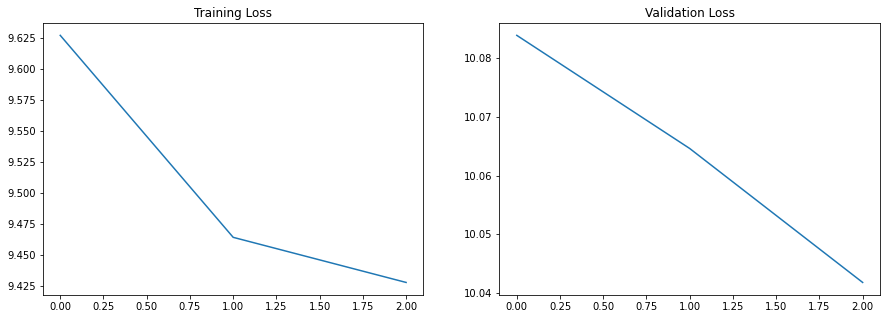

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

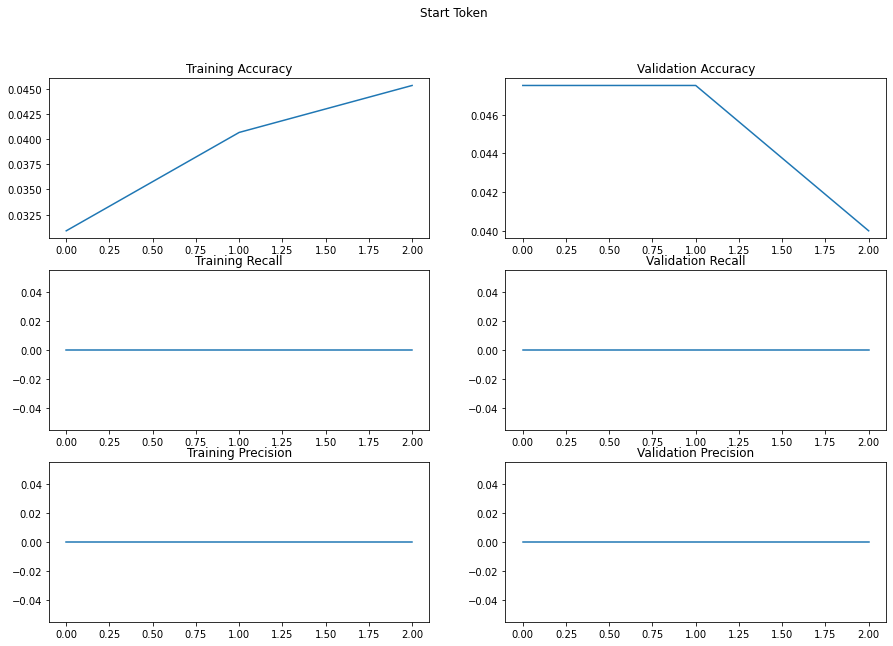

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('Start Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['start_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_start_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['start_token_out_recall'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_start_token_out_recall'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['start_token_out_precision'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_start_token_out_precision'])
plt.show()

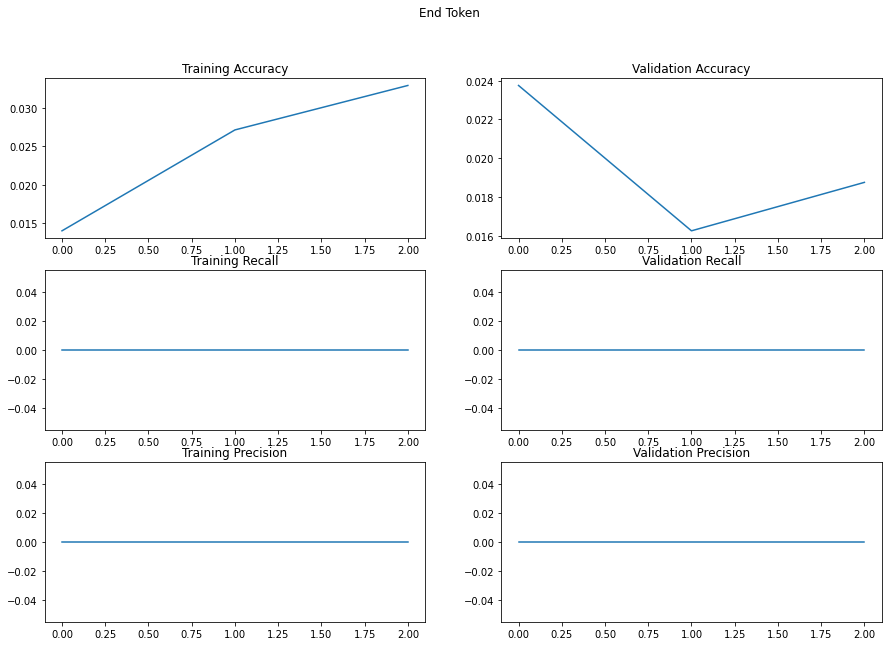

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('End Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['end_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_end_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['end_token_out_recall_1'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_end_token_out_recall_1'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['end_token_out_precision_1'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_end_token_out_precision_1'])
plt.show()

In [26]:
accuracy = history.history['start_token_out_categorical_accuracy'][-1]
recall = history.history['start_token_out_recall'][-1]
precision = history.history['start_token_out_precision'][-1]


print('Training')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['end_token_out_categorical_accuracy'][-1]
recall = history.history['end_token_out_recall_1'][-1]
precision = history.history['end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Training
Start token accuracy: 0.04533333331346512
Start token recall: 0.0
Start token precision: 0.0


ZeroDivisionError: ignored

In [27]:
accuracy = history.history['val_start_token_out_categorical_accuracy'][-1]
recall = history.history['val_start_token_out_recall'][-1]
precision = history.history['val_start_token_out_precision'][-1]


print('Validation')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['val_end_token_out_categorical_accuracy'][-1]
recall = history.history['val_end_token_out_recall_1'][-1]
precision = history.history['val_end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Validation
Start token accuracy: 0.03999999910593033
Start token recall: 0.0
Start token precision: 0.0


ZeroDivisionError: ignored

#### Making Predictions to see how the model is performing

In [33]:
def test_answer(question, context):
    sentences = [context, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)]
    )
    
    predictions = np.array(predictions)
    
    pred_start = np.argmax(predictions[0,0])
    pred_end = np.argmax(predictions[1,0])
    pred_string = ' '.join(context.split(' ')[pred_start:pred_end])

    return pred_start, pred_end, pred_string

In [34]:
context = train_data.context[0]
question = train_data.questions[0]

In [35]:
start, end, answer = test_answer(question, context)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + answer)

Start token: 46
End token: 26
Answer: 


## Conclusion 

- It took us a lot of time trying to figure out how to tuckle the problem statement. Although, the beginning of the task was somewhat cumbersome we consulted some online resources like [kaggle](https://www.kaggle.com/), [hugging face](https://huggingface.co/), [tensorflow hub](http://tfhub.dev/) and many others to show us the way. 
- Although, BERT has proven to work well with the question answering tasks, due to the knowledge we seek to get from the project we conformed to going through the many mini steps, even from preprocessing of a json complex dataset into a more simpler one to feed into a neural network after several cleaning preprocesses. BERT, we considered to fall into the "Black Box" tasks and not much knowledge is retrieved as you learn through.